In [ ]:
# Example of training NN with Elegy then doing HMC with Oryx on Mana
# Author: Peter Oct 22 2021
# Requirements: 
#!module load system/CUDA/11.0.2 
#!pip install --upgrade jax jaxlib==0.1.68+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html 
#!pip install tensorflow-io oryx elegy

In [2]:
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.10'
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad

assert jax.default_backend() == 'gpu'

import oryx  # pip install oryx
import elegy # pip install elegy
import optax
#import flax.linen
import tensorflow_io as tfio # pip install tensorflow-io
import tensorflow as tf # Recommended not to import this with jax because will also try to grab memory.

tfd = oryx.distributions

state = oryx.core.state
ppl = oryx.core.ppl

inverse = oryx.core.inverse
ildj = oryx.core.ildj
plant = oryx.core.plant
reap = oryx.core.reap
sow = oryx.core.sow
unzip = oryx.core.unzip

nn = oryx.experimental.nn
mcmc = oryx.experimental.mcmc
optimizers = oryx.experimental.optimizers # Oryx based on https://github.com/deepmind/optax
#optimizer = optimizers.adam(1e-4) # Oryx based on https://github.com/deepmind/optax
#opt_state = state.init(optimizer)(opt_key, network, network)

# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
#f = './data_processed_sample.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/features')
y = tfio.IODataset.from_hdf5(f, dataset='/logp1_flux')
full = tf.data.Dataset.zip((x, y))
#assert full.cardinality().numpy() == 1435308, full.cardinality().numpy()
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Preprocess.
INPUT_MEANS = np.array([41.094597, 6.4734573, 160.1557, 1.0845096, 1.3110111, 1.1005557, 1.2972884])
#train = train.apply(lambda x: x - input_means)
#test = test.apply(lambda y: y**2)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


In [8]:
class Scale(elegy.Module):
    """
    Elegy nn layer module that scales input data by constant values.
    """
    def __init__(self, scale: np.ndarray, **kwargs):
        """
        Constructs a `Scale` layer module.
        Args:
            scale: Vector representing values to scale each input.
            kwargs: Additional keyword arguments passed to Module.
        Raises:
            ValueError: If `preserve_dims` is not positive.
        """        
        self.scale = scale
        super().__init__(**kwargs)

    def call(self, inputs: np.ndarray) -> np.ndarray:
        """
        Arguments:
            inputs: the array to be transformed.
        Returns:
            A transformed array.
        """
        return inputs / self.scale
        
class MLP(elegy.Module):
    # Defines stateful model. See elegy docs.
    # def __init__(self, scale: np.ndarray, **kwargs):
    #     self.Scale = Scale(scale)
    #     super().__init__(**kwargs)
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        x = x / INPUT_MEANS # This works. 
        x = elegy.nn.Linear(1024)(x)
        x = jax.nn.relu(x)
        x = elegy.nn.Linear(1024)(x)
        x = jax.nn.tanh(x)
        x = elegy.nn.Linear(245)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=elegy.losses.MeanSquaredError(),
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
x = np.random.rand((7))
print(x)
print(model.predict(x))

# history = model.fit(
#     x=train,
#     epochs=10,
#     steps_per_epoch=10000,
#     validation_data=test,
#     validation_steps=1000,
#     shuffle=False,
#     verbose=1,
#     #callbacks=[elegy.callbacks.TensorBoard("summaries")]
# )

# # Save model. 
# model.save('my_model')  # creates folder at 'my_model'
# del model  # deletes the existing model
# # returns a model identical to the previous one
# model = elegy.load('my_model')
# #print(model.states.rng)
# # Test ability to make prediction.
# x = np.random.rand((7))
# model.predict(x).shape

[0.99094748 0.66716901 0.21630685 0.89891157 0.50265655 0.16770621
 0.65695886]
[0.02411381 0.10306224 0.0013506  0.8288646  0.38341138 0.15238321
 0.5064093 ]


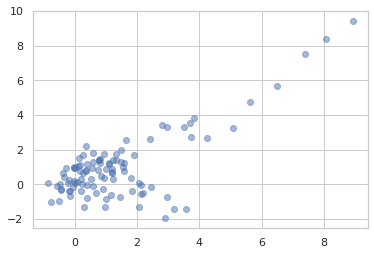

In [4]:
# Test that we can use this model with Oryx.
model.run_eagerly = True # Settable attribute. Required to be true for ppmodel.

def ppmodel(key):
  # Define probabilistic programming model as a random sample from input space, 
  # then application of NN, then computation of likelihood.

  # First sample from 7-D gaussian. This is the prior.
  x = ppl.random_variable(tfd.MultivariateNormalDiag(jnp.zeros(7), jnp.ones(7)), name='x')(key)
  # Apply NN.
  yhat = model.predict(x) # Reminder: model should be in eager mode.
  # Compute unnormalized likelihood by comparing prediction with data.
  y = 2. # This is our observed data (only one point in this example.)
  likelihood = jnp.exp((yhat - y)**2) # MSE of prediction.
  return likelihood

start = 10*jnp.ones(7) # This is the starting state for MCMC.
samples = jit(mcmc.sample_chain(mcmc.hmc(ppl.joint_log_prob(ppmodel)), 100))(random.PRNGKey(0), start) # use log_prob doesn't work because function too complex.

# Plot 7d samples from the posterior in 2d.
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.show()